## **Libraries**

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
import plotly.express as px
from plotly import subplots
from folium.plugins import HeatMap, HeatMapWithTime
import folium

In [15]:
olist_df = pd.read_pickle('/content/processed_dataset.pkl')

In [36]:
geolocation_df = pd.read_csv('/content/olist_geolocation_dataset.csv')

In [16]:
olist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114422 entries, 0 to 114421
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  114422 non-null  object        
 1   order_purchase_timestamp  114422 non-null  datetime64[ns]
 2   datetime                  114422 non-null  datetime64[ns]
 3   diff_days                 114422 non-null  int64         
 4   weekly                    114422 non-null  UInt32        
 5   product_id                114422 non-null  object        
 6   seller_id                 114422 non-null  object        
 7   price                     114422 non-null  float64       
 8   freight_value             114422 non-null  float64       
 9   product_category_name     114422 non-null  object        
 10  seller_zip_code_prefix    114422 non-null  int64         
 11  seller_city               114422 non-null  object        
 12  se

## **Exploratory Data Analysis**

* Difference from the average number of days per week

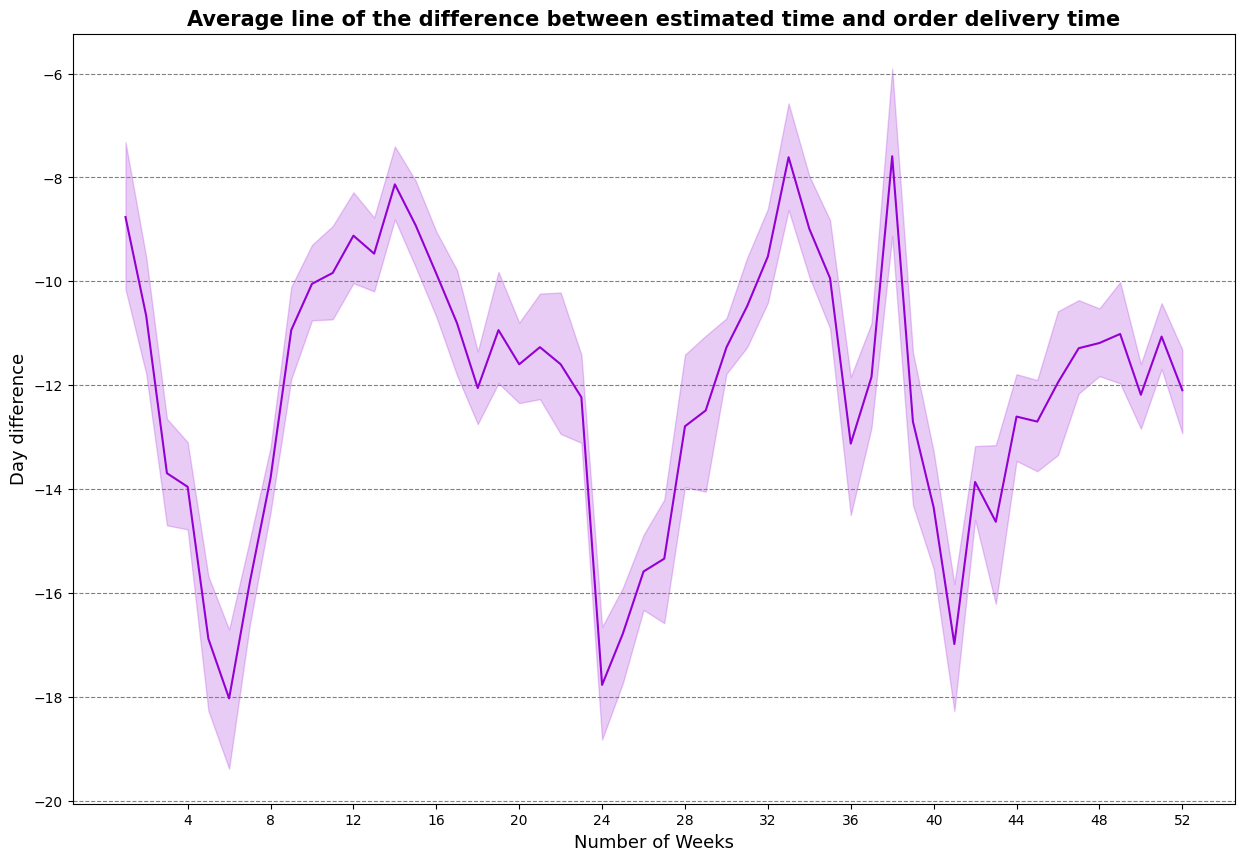

In [17]:
plt.figure(figsize=(15,10))

sns.lineplot(x = 'weekly', y = 'diff_days', data = olist_df, color ="darkviolet", linewidth=1.5,
            markers = True, dashes = False, estimator = 'mean')

plt.xticks(range(4, 53, 4), range(4, 53, 4))

plt.xlabel("Number of Weeks", size = 13)
plt.ylabel("Day difference", size = 13)

plt.title("Average line of the difference between estimated time and order delivery time",size = 15, weight = 'bold')
plt.grid(True, linestyle='--', linewidth=0.8, color='gray', which='both', axis='y')

plt.show()

The graph shows the middle line of the average difference between the actual delivery time and the estimated delivery time in different weeks.
> We can infer that the first deliveries were made in approx. **February** (8 weeks), **July** (28 weeks) and **October** (40 weeks). It means that these months are the least intensive periods of those years.

> And the last deliveries were made at the end of **March** (week 12) and beginning of **April** (week 16). And others at the beginning of **August** (week 32). It means that these periods are the most intense of those years.

### **Products**

* The most purchased product category.

In [19]:
product_price = olist_df.groupby(["product_category_name"])["price"].sum().sort_values(ascending=False).head(5)
df = product_price.reset_index(name='total_price')

trace = go.Bar(
    y = df['product_category_name'],
    x = df['total_price'],
    orientation='h',
    marker = dict(color = ['green', '#88B688', '#879F87', '#899989', '#A2A99F']),
    text = df['total_price']
)

layout = go.Layout(title='Total price per product category', xaxis=dict(title='Total price (R$)'), yaxis=dict(title='Product Category',autorange='reversed'))
fig = go.Figure(data=[trace], layout=layout)
iplot(fig, filename='horizontal-bar')

* The most requested product category

In [20]:
product_data = olist_df.groupby(["product_category_name"])["product_id"].count().sort_values(ascending=False).head(5)
df = product_data.reset_index(name='count')

trace = go.Bar(
    y = df['product_category_name'],
    x = df['count'],
    orientation='h',
    marker = dict(color = ['green', '#88B688', '#879F87', '#899989', '#A2A99F']),
    text = df['count']
)

layout = go.Layout(title='Product category with the highest number of orders', xaxis=dict(title='Order Quantity'), yaxis=dict(title='Product Category',autorange='reversed'))
fig = go.Figure(data=[trace], layout=layout)
iplot(fig, filename='horizontal-bar')

* Most requested products within each order

In [21]:
product_data = olist_df.groupby(['product_id','product_category_name',])['product_id'].count().sort_values(ascending=False).head(5)
df = product_data.reset_index(name='count')

trace = go.Bar(
    y = df['product_category_name'],
    x = df['count'],
    orientation='h',
    marker = dict(color = ['green', '#88B688', '#879F87', '#899989', '#A2A99F']),
    text = df['count']
)

layout = go.Layout(title='Category of most requested products within each order', xaxis=dict(title='Order Quantity'), yaxis=dict(title='Product Category',autorange='reversed'))
fig = go.Figure(data=[trace], layout=layout)
iplot(fig, filename='horizontal-bar')

### **Sellers**

* Seller with the most products by category sold

In [22]:
seller_data = olist_df.groupby(['seller_id_small', 'product_category_name'])['seller_id_small'].count().sort_values(ascending=False).head(5)
df = seller_data.reset_index(name='count')

trace = go.Bar(
    y = df['seller_id_small'],
    x = df['count'],
    orientation='h',
    marker = dict(color = ['green', '#88B688', '#879F87', '#899989', '#A2A99F']),
    text = df['count']
)

layout = go.Layout(title='Seller with the most products by category sold', xaxis=dict(title='Order Quantity'), yaxis=dict(title='Seller ID',autorange='reversed'))
fig = go.Figure(data=[trace], layout=layout)
iplot(fig, filename='horizontal-bar')

### Orders

* Number of orders for number of products.

In [23]:
count_products = olist_df.groupby('order_id').size().value_counts().head(6)

trace = go.Bar(
    y = count_products.index,
    x = count_products.values,
    orientation='h',
    marker = dict(color = ['green', '#88B688', '#879F87', '#899989', '#A2A99F']),
    text = count_products.values
)

layout = go.Layout(title='Number of orders times number of products', xaxis=dict(title='Number of Products'), yaxis=dict(title='Number of Orders',autorange='reversed'))
fig = go.Figure(data=[trace], layout=layout)
iplot(fig, filename='horizontal-bar')

> We can infer that there are more purchase orders (Customers) who prefer to buy per unit.

* Graph of 'product value' and 'freight' value on linear scale and logarithmic scale

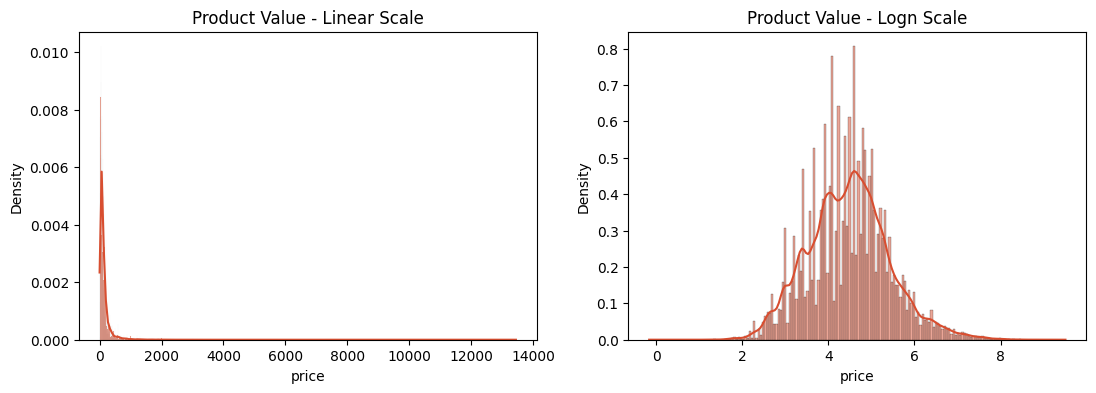

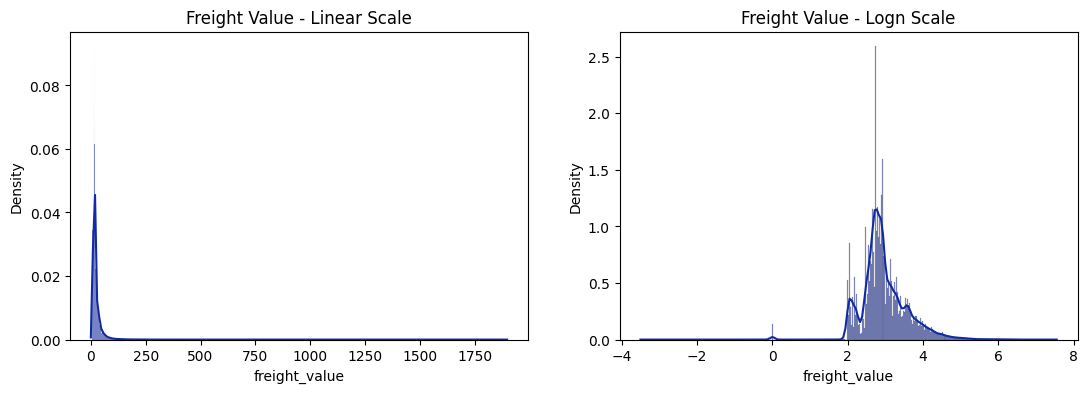

In [24]:
def plotDist(values, log_values, title, color="#D84E30"):
    fig, axis = plt.subplots(1, 2, figsize=(13,4))
    axis[0].set_title("{} - Linear Scale".format(title))
    axis[1].set_title("{} - Logn Scale".format(title))
    ax1 = sns.histplot(values, color=color, ax=axis[0], kde=True, stat="density")
    ax2 = sns.histplot(log_values, color=color, ax=axis[1], kde=True, stat="density")

# Products value
sum_value = olist_df.groupby('order_id')['price'].sum()
plotDist(sum_value, np.log(sum_value), 'Product Value')
# Freights value
sum_value = olist_df.groupby('order_id')['freight_value'].sum()
plotDist(sum_value, sum_value.apply(lambda x: np.log(x) if x > 0 else 0), 'Freight Value', color="#122aa5")

The previous graphs are interpreted as:
> **Linear scale graph of "Product Value" and "Freight" value**:
  
   The high peak between **R$0** to **R\$2.000** suggests that there are many orders with low prices overall, but does not directly indicate whether they represent the highest total value.

> **Logarithmic scale graph of "Product Value" and "Freight" value**:

   The high peak between 2 and 8 on the logarithmic scale (corresponding to **R$100** to **R\$100'000.000** on the linear scale) suggests that there are few orders with high prices, but does not necessarily indicate whether they are the most profitable or whether they represent the majority of the benefit.

* Product value and freight by date and Sales per month (product value)

In [25]:
# Product value by date
value_date = olist_df.groupby([olist_df['datetime'].dt.date])['price'].sum()
freight_date = olist_df.groupby([olist_df['datetime'].dt.date])['freight_value'].sum()
# Plot timeseries
trace0 = go.Scatter(x=value_date.index.astype(str), y=value_date.values, opacity = 0.8, name='Product Value')
trace1 = go.Scatter(x=freight_date.index.astype(str), y=freight_date.values, opacity = 0.8, name='Freight Value')
layout = dict(
    title= "Product value and freight by date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=12, label='12m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date'
    )
)
fig = dict(data= [trace0, trace1], layout=layout)
iplot(fig)

# Sales for month
value_month = olist_df[['datetime', 'price']].copy()
value_month.set_index('datetime', inplace=True)
value_month = value_month.groupby(pd.Grouper(freq="M"))['price'].sum()
trace = go.Bar(x= value_month.index, y= value_month.values)
layout = go.Layout(title='Sales per month (product value)')
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

Some inferences were:

> There is a peak or increase in the value of products on November 24 due to events such as Black Friday.

> Sales are weak in mid-December due to events such as year-end holidays.

> In 2016, there were very few sales except for the month of October.

### Payments

* Statistical summary of the set of numerical columns of the 'payments' dataset

In [26]:
olist_df[['payment_sequential', 'payment_installments', 'payment_value', 'value_log']].describe()

,payment_sequential,payment_installments,payment_value,value_log
count,114422.000000,114422.000000,114422.000000,114422.000000
mean,1.093688,2.944268,171.417184,4.679106
std,0.730507,2.778938,263.579511,0.959100
min,1.000000,0.000000,0.000000,-4.605170
25%,1.000000,1.000000,60.850000,4.108412
50%,1.000000,2.000000,107.880000,4.681019
75%,1.000000,4.000000,189.055000,5.242038
max,29.000000,24.000000,13664.080000,9.522526


* Graph of the 'values paid' on a linear scale and on a logarithmic scale

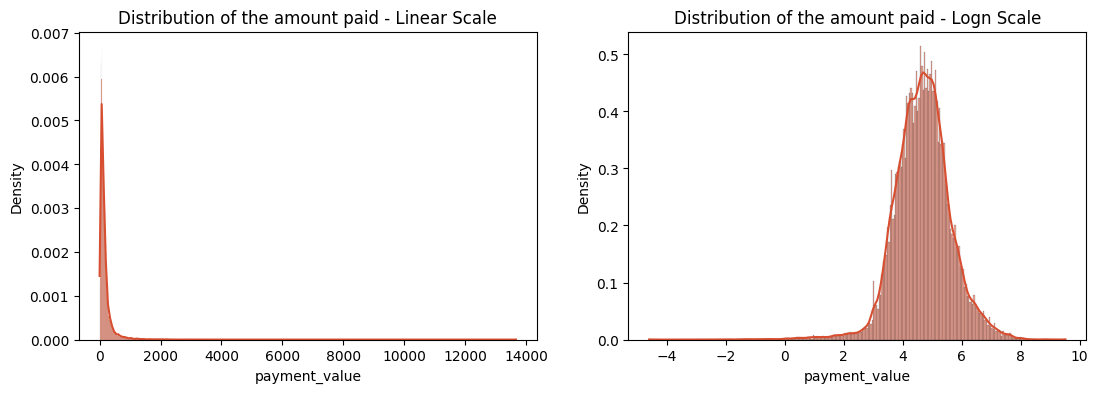

In [27]:
log_value = olist_df.payment_value.apply(lambda x: np.log(x) if x > 0 else 0)
plotDist(olist_df.payment_value, log_value, "Distribution of the amount paid")

* Pie graphs of 'number of payments' and 'value of payments'

In [28]:
method_count = olist_df['payment_type'].value_counts().to_frame().reset_index()
method_value = olist_df.groupby('payment_type')['payment_value'].sum().to_frame().reset_index()
# Plotly piechart
colors = None
trace1 = go.Pie(labels = method_count['payment_type'], values = method_count['count'],
                domain = {'x': [0, .48]}, marker = dict(colors = colors))
trace2 = go.Pie(labels = method_value['payment_type'], values = method_value['payment_value'],
                domain = {'x': [0.52, 1]}, marker = dict(colors = colors))
layout = dict(title = "Number of payments by payment method        Payment value by payment method",
              height = 400, width = 800,)
fig = dict(data = [trace1, trace2], layout = layout)
iplot(fig)

* Function to create a graph that compares the distribution of payment values 'payment_value' by payment type 'payment_type'

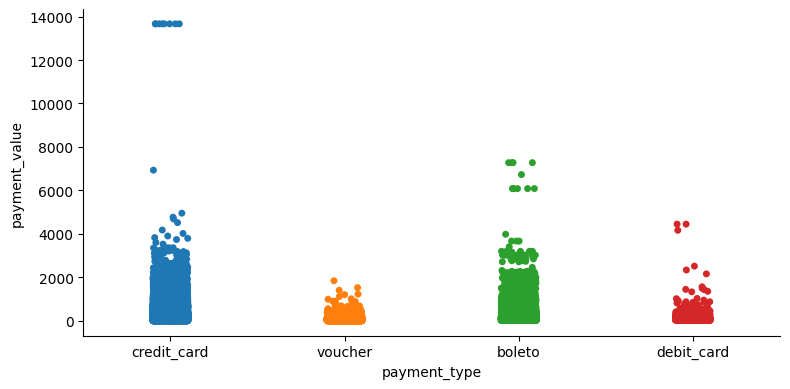

In [29]:
ax = sns.catplot(x = "payment_type", y = "payment_value",data = olist_df, aspect = 2, height = 4, hue = "payment_type", palette = sns.color_palette()[:4])

* Kernel density plot for payment type distribution on a logarithmic scale

<Axes: title={'center': 'Distributions of payment methods on logn scale'}, xlabel='value_log', ylabel='Density'>

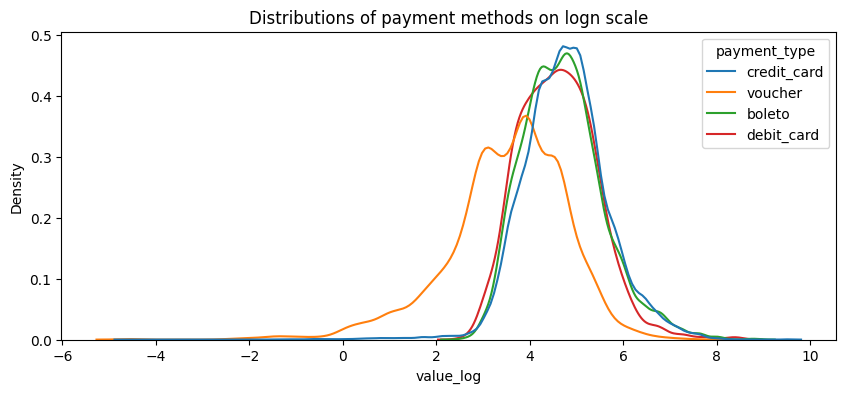

In [30]:
plt.figure(figsize = (10,4))
plt.title("Distributions of payment methods on logn scale")
sns.kdeplot(data = olist_df, x = "value_log", hue = "payment_type", fill = False, common_norm = False, alpha = 1)

### Installments

* Payment methods with more than one installment

In [31]:
olist_df[olist_df['payment_installments'] > 1]['payment_type'].value_counts().to_frame()

,count
payment_type,
credit_card,57424


> Only credit cards can have more than one fee

* Number of Installments

In [33]:
ins_count = olist_df.groupby('payment_installments').size()
ins_mean = olist_df.groupby('payment_installments')['payment_value'].mean()

trace0 = go.Bar(
    x = ins_count.index,
    y = ins_count.values,
    name = 'Number of Orders by installments',
    marker = dict(color='rgb(49,130,189)')
)
trace1 = go.Bar(
    x = ins_mean.index,
    y = ins_mean.values,
    name = 'Average value by installments',
    marker = dict(color='rgba(222,45,38,0.8)')
)
fig = subplots.make_subplots(rows = 1, cols = 2, print_grid = False)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(height = 400, width = 800, title = 'Number of Installments',
                     legend = dict(orientation = "h"))
iplot(fig)

> When we plot the number of installments we can see some patterns. Most sellers in Brazil offer the option to split the payment into up to 10 installments and the average value of the product increases up to that number.

* Number of orders and the total value of payments with a single installment

In [34]:
pay_one_inst = olist_df[olist_df['payment_installments'] == 1]
method_count = pay_one_inst['payment_type'].value_counts().to_frame().reset_index()
method_value = pay_one_inst.groupby('payment_type')['payment_value'].sum().to_frame().reset_index()
# Plotly piechart
colors = None
trace1 = go.Pie(labels = method_count['payment_type'], values = method_count['count'],
                domain = {'x': [0, .48]}, marker = dict(colors = colors))
trace2 = go.Pie(labels = method_value['payment_type'], values = method_value['payment_value'],
                domain = {'x': [0.52, 1]}, marker=dict(colors = colors))
layout = dict(title = "Number of orders<br>by payment methods                             Value paid for a single installment",
              height = 400, width = 800,)
fig = dict(data = [trace1, trace2], layout = layout)
iplot(fig)

### Geolocation

* Heat map of customer distribution in Brazil and South America

In [38]:
# A heat map is created with HeatMap
map = folium.Map(location = [-14.235, -51.9253], zoom_start = 4, tiles = 'cartodbdark_matter')  # Approximate coordinates of the center of Brazil

# Converts coordinates to (latitude, longitude) format for HeatMap
# 75% of the data ALREADY GIVES ERROR
data = geolocation_df[['geolocation_lat', 'geolocation_lng']].head(750122).values.tolist()

# The heat map is created with HeatMap
folium.plugins.HeatMap(data).add_to(map)
map

Output hidden; open in https://colab.research.google.com to view.

* Geolocation distribution by state

In [40]:
ordered_states = geolocation_df['geolocation_state'].value_counts().sort_values().index

ordered_df = pd.DataFrame(geolocation_df['geolocation_state'].value_counts().sort_values()).reset_index().tail(5)
ordered_df.columns = ['geolocation_state', 'count']

fig = px.bar(ordered_df, x='count', y='geolocation_state',
             title='Geolocation distribution by state',
             labels={'geolocation_state': 'Geolocation status', 'count': 'Count'},
             category_orders={'geolocation_state': ordered_states}, color='geolocation_state')
fig.show()

### Reviews

* Reviews Score

In [41]:
review_qty = olist_df.groupby('review_score').size()
review_value = olist_df.groupby('review_score')['price'].mean()
trace0 = go.Bar(
    x=review_qty.index,
    y=review_qty.values,
    name='Number of Orders',
    marker=dict(color='rgba(222,45,38,0.8)')
)
trace1 = go.Bar(
    x=review_value.index,
    y=review_value.values,
    name='Average product<br>value',
    marker=dict(color='rgb(49,130,189)')
)
fig = subplots.make_subplots(rows=1, cols=2, print_grid=False)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(height=400, width=800, title='Score del Review')
fig['layout']['xaxis1'].update(title='review score', domain=[0, 0.40])
fig['layout']['xaxis2'].update(title='review score', domain=[0.6, 1])
iplot(fig)

> Most ratings are good and the bad ones seem to be related to slightly more expensive products or larger orders.

* Number of Reviews by Creation Date

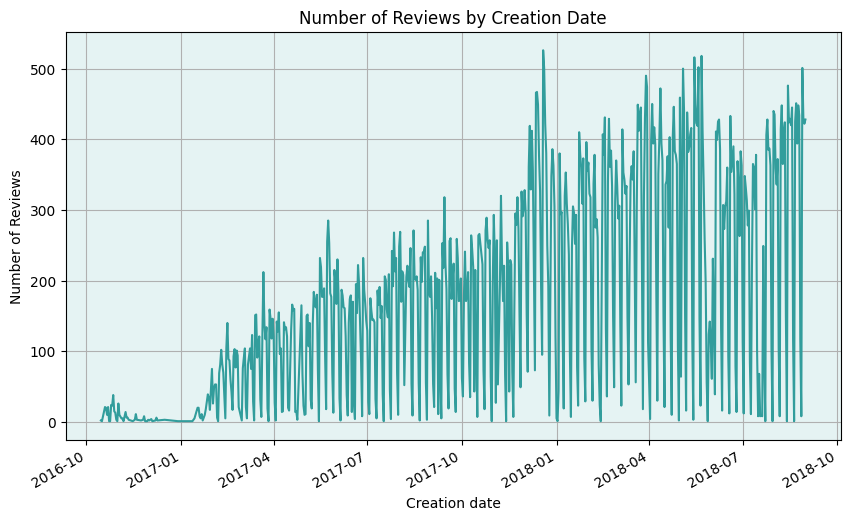

In [42]:
reviews_per_date = olist_df.groupby('review_creation_date').size()

plt.figure(figsize=(10, 6))
reviews_per_date.plot(color='#329D9C')
plt.gca().set_facecolor('#E5F3F3')

plt.title('Number of Reviews by Creation Date')
plt.xlabel('Creation date')
plt.ylabel('Number of Reviews')
plt.grid(True)


plt.show()

* Number of Responses per Time of Day

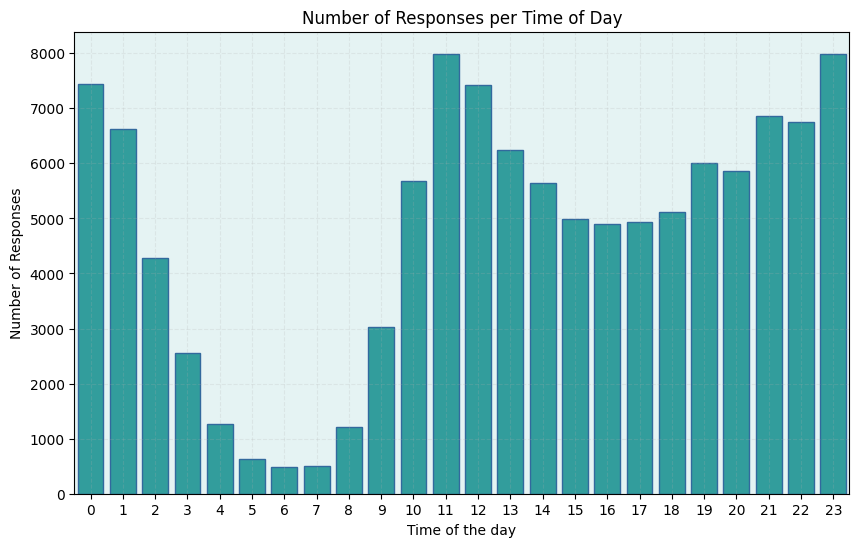

In [43]:
answers_per_hour = olist_df.groupby('answer_hour').size()

plt.figure(figsize=(10, 6))
plt.bar(answers_per_hour.index, answers_per_hour, color='#329D9C', width=0.8, edgecolor='#32699D')

plt.gca().set_facecolor('#E5F3F3')


plt.grid(True, linestyle='--', alpha=0.2)


plt.title('Number of Responses per Time of Day')
plt.xlabel('Time of the day')
plt.ylabel('Number of Responses')
plt.xticks(range(24))
plt.xlim(-0.5, 23.5)

plt.show()

* Average Score by Day of the Month

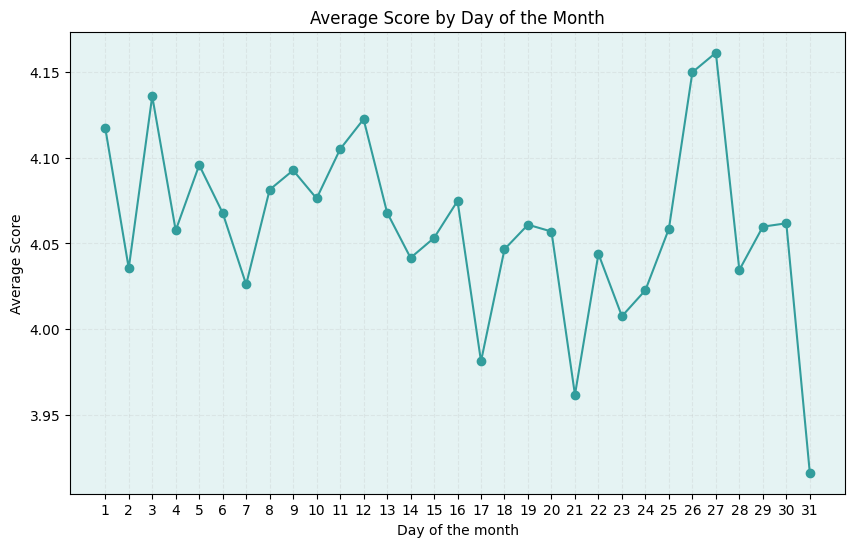

In [44]:
average_score_per_day = olist_df.groupby('day_of_month')['review_score'].mean()

plt.figure(figsize=(10, 6))
plt.plot(average_score_per_day.index, average_score_per_day, marker='o', color='#329D9C', linestyle='-')
plt.gca().set_facecolor('#E5F3F3')


plt.title('Average Score by Day of the Month')
plt.xlabel('Day of the month')
plt.ylabel('Average Score')

plt.xticks(range(1, max(olist_df['day_of_month']) + 1))

plt.grid(True, linestyle='--', alpha=0.2)

plt.show()

* Average Score by City (Top 20)

In [45]:
score_by_city = olist_df.groupby('customer_city')['review_score'].mean()
reviews_count_by_city = olist_df['customer_city'].value_counts()
city_stats = pd.DataFrame({'avg_review_score': score_by_city, 'reviews_count': reviews_count_by_city})
city_stats = city_stats.sort_values(by='reviews_count', ascending=False)

print(city_stats)

                 avg_review_score  reviews_count
customer_city                                   
sao paulo                4.156779          18019
rio de janeiro           3.862324           7968
belo horizonte           4.070662           3170
brasilia                 4.017399           2414
curitiba                 4.128104           1772
...                           ...            ...
pureza                   5.000000              1
pugmil                   3.000000              1
estrela d oeste          5.000000              1
estrela d'oeste          5.000000              1
zortea                   3.000000              1

[4082 rows x 2 columns]


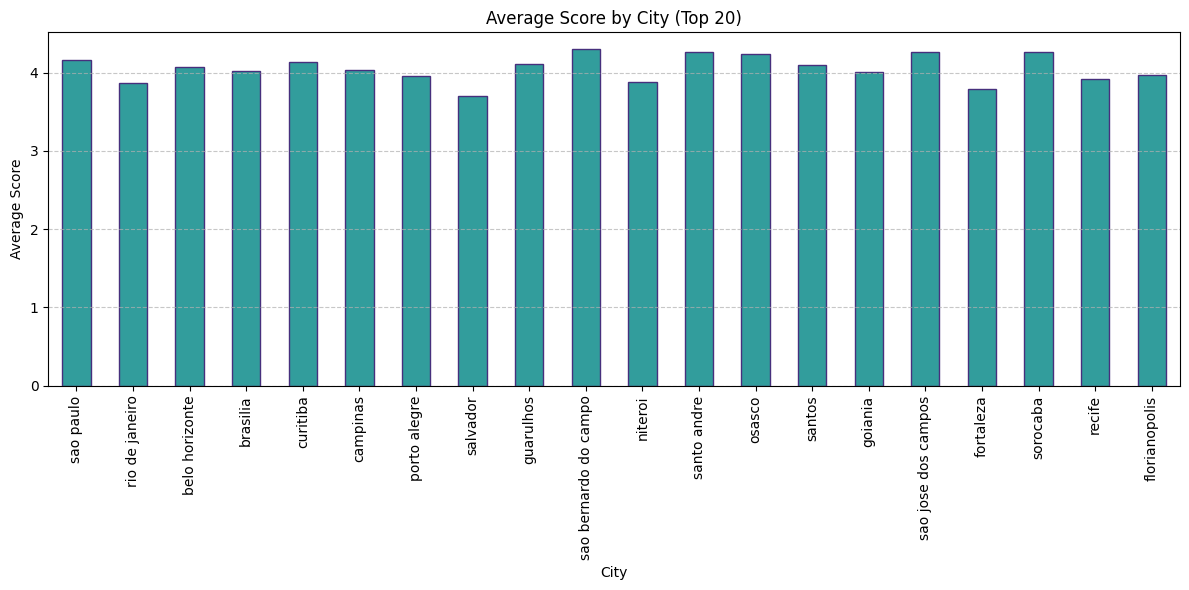

In [46]:
top_20_cities = city_stats.head(20)

plt.figure(figsize=(12, 6))
top_20_cities['avg_review_score'].plot(kind='bar', color='#329D9C', edgecolor='#472F7D')
plt.title('Average Score by City (Top 20)')
plt.xlabel('City')
plt.ylabel('Average Score')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()